# Block timestamp analysis

Analysis by [IsthmusCrypto](https://github.com/mitchellpkt)

Blocks courtesy of [NeptuneResearch](https://github.com/neptuneresearch)

Study for the [Monero Archival Project](https://github.com/mitchellpkt/monero_archival_project), a product of *#Noncesense-research-lab*

**Background:**

Miners can arbitrarily choose the timestamps that they include in the block, so MAP retains both the miner-reported timestamp (MRT) and the node-receipt timestamp (NRT).Comparison of the timestamps in the block against the timestamps when the block was received will reveal how often the miner-reported timestamps are spoofed.

Similarly, we can look for signs of [selfish mining](https://arxiv.org/pdf/1311.0243.pdf) based on the timing with which blocks are received. Ittay Eyal and Emin Gün Sirer [point out](http://hackingdistributed.com/2014/01/15/detecting-selfish-mining/) that "One could detect this [phenomenon] by looking at the timestamps on successive blocks in the blockchain. Since mining is essentially an independent random process, we'd expect the interblock time gap to be exponentially distributed. Any deviation from this expectation would be suggestive of selfish mining."

**Questions:**
-  How accurate are miner-reported timestamps? 
-  How many instances of each block are received by a given node? 
-  What is the time between first receipt and last receipt of a new block
-  What distribution fits the wait time, and are there any significant deviations?

## Mark block height

In [1]:
blockchain_synced_at_height = 1628960 # initially at 1627831, but had some downtime for a few hours



## Import libraries

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from copy import copy

## Import the data

In [3]:
df = pd.read_csv('data_for_analysis/uncompressed/MRTNRTSing.log', sep="=", 
                 names = ["peer_ID", 
                         "height", 
                         "MRT",
                         "NRT"])

df.head()

,peer_ID,height,MRT,NRT
0,/home/map/.bitmonero/bitmonero.log:2018-08-02 ...,1629904 MRT,1533184122 NRT,1533184209387]
1,/home/map/.bitmonero/bitmonero.log:2018-08-02 ...,1629905 MRT,1533184209 NRT,1533184257636]
2,/home/map/.bitmonero/bitmonero.log:2018-08-02 ...,1629906 MRT,1533184257 NRT,1533184281130]
3,/home/map/.bitmonero/bitmonero.log:2018-08-02 ...,1629907 MRT,1533184280 NRT,1533184432483]
4,/home/map/.bitmonero/bitmonero.log:2018-08-02 ...,1629908 MRT,1533184733 NRT,1533184752493]


## Wrangle the data

In [4]:
# Remove the text
df['height'] = df['height'].str.extract('(\d+)').astype(int)
df['MRT'] = df['MRT'].str.extract('(\d+)').astype(int)
df['NRT'] = df['NRT'].str.extract('(\d+)').astype(int)

Convert the NRT from milliseconds to seconds, to match MRT

In [5]:
df['NRT'] = df['NRT']/1000
df['NRT']=df['NRT'].astype(int)

Mark down which blocks contain MAIN in the `peer_ID` field

In [6]:
df['main_chain'] = 0
#df['main_chain'][df['peer_ID'].str.contains("MAIN")] = 1
df.loc[df.peer_ID.str.contains("MAIN"), ('main_chain')] = 1

Extract peer info

In [7]:
# Take only [P2PX]
df['peer_ID'] = df.peer_ID.str.split('\s+').str[2]
df.head(15)

,peer_ID,height,MRT,NRT,main_chain
0,[P2P2],1629904,1533184122,1533184209,1
1,[P2P8],1629905,1533184209,1533184257,1
2,[P2P8],1629906,1533184257,1533184281,1
3,[P2P9],1629907,1533184280,1533184432,1
4,[P2P3],1629908,1533184733,1533184752,1
5,[P2P5],1629909,1533184752,1533185053,1
6,[P2P4],1629910,1533185054,1533185249,1
7,[P2P8],1565690,1525470502,1533185350,0
8,[P2P8],1629911,1533185249,1533185555,1
9,[P2P3],1629912,1533185555,1533185565,1


## Feature engineering

Record the time between MRT and NRT. I label this **ostensible** because it is calculated based on the spoofable (and often inaccurate MRT)

In [8]:
df['ostensible_detection_lag'] = df['NRT'] - df['MRT']

Split off `df_main` without alt blocks

In [9]:
main_chain_inds = df.index[df['main_chain'] == 1]
df_main = copy(df[df['main_chain']==1])

# Calculate time deltas
df_main['delta_MRT'] = df_main['MRT']-df_main['MRT'].shift()
df_main['delta_NRT'] = df_main['NRT']-df_main['NRT'].shift()

# Label Merlin blocks
df_main['merlin_block'] = 0 # unnecessary?
df_main['merlin_block'] = df_main['MRT'].transform(lambda x: x < 0).astype(int)

# Drop the first block, missing deltas
df_main = copy(df_main.iloc[1:])

df_main.head(10)

,peer_ID,height,MRT,NRT,main_chain,ostensible_detection_lag,delta_MRT,delta_NRT,merlin_block
1,[P2P8],1629905,1533184209,1533184257,1,48,87.0,48.0,0
2,[P2P8],1629906,1533184257,1533184281,1,24,48.0,24.0,0
3,[P2P9],1629907,1533184280,1533184432,1,152,23.0,151.0,0
4,[P2P3],1629908,1533184733,1533184752,1,19,453.0,320.0,0
5,[P2P5],1629909,1533184752,1533185053,1,301,19.0,301.0,0
6,[P2P4],1629910,1533185054,1533185249,1,195,302.0,196.0,0
8,[P2P8],1629911,1533185249,1533185555,1,306,195.0,306.0,0
9,[P2P3],1629912,1533185555,1533185565,1,10,306.0,10.0,0
10,[P2P6],1629913,1533185746,1533185803,1,57,191.0,238.0,0
11,[P2P8],1629914,1533185803,1533185811,1,8,57.0,8.0,0


## Plots / analysis

### Plot MRT vs NRT

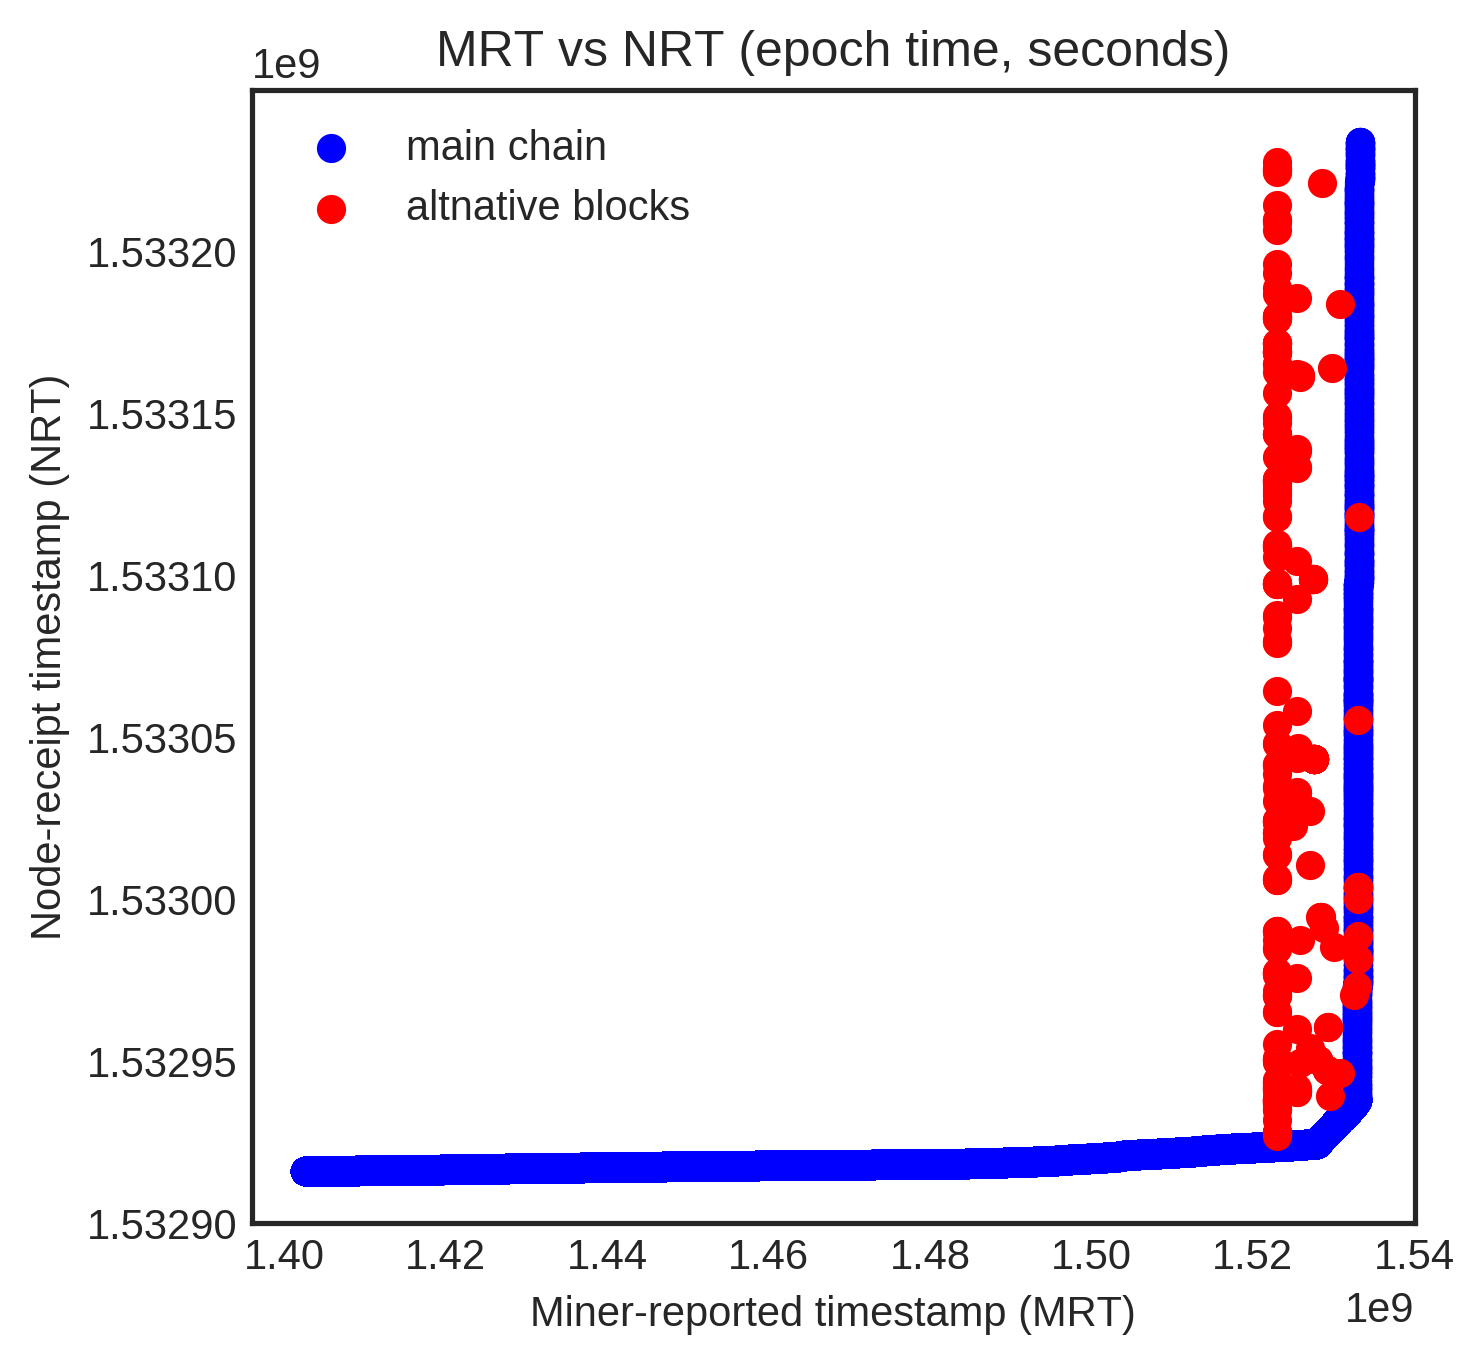

In [10]:
MRT_vs_NRT = plt.figure(figsize=(5,5),facecolor='white', dpi=300)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['font.size'] = 10

main_chain_inds = df.index[df['main_chain'] == 1]
alt_block_inds = df.index[df['main_chain'] == 0]

plt.scatter(df['MRT'][main_chain_inds], df['NRT'][main_chain_inds], c='blue', label= 'main chain')
plt.scatter(df['MRT'][alt_block_inds], df['NRT'][alt_block_inds], c='red', label = 'altnative blocks')

plt.xlabel('Miner-reported timestamp (MRT)')
plt.ylabel('Node-receipt timestamp (NRT)')
plt.title('MRT vs NRT (epoch time, seconds)')
plt.legend()
pass

The horizontal portion of the blue line is the blockchain sync. The vertical-ish portion is operation at height. The red dots show when we received alternative blocks

Looks pretty reasonable. Ultimately, we're interested in deviations away from the 1:1 line, so a histograms of the difference would be more informative

### Plot a histogram of MRT - NRT for main chain blocks

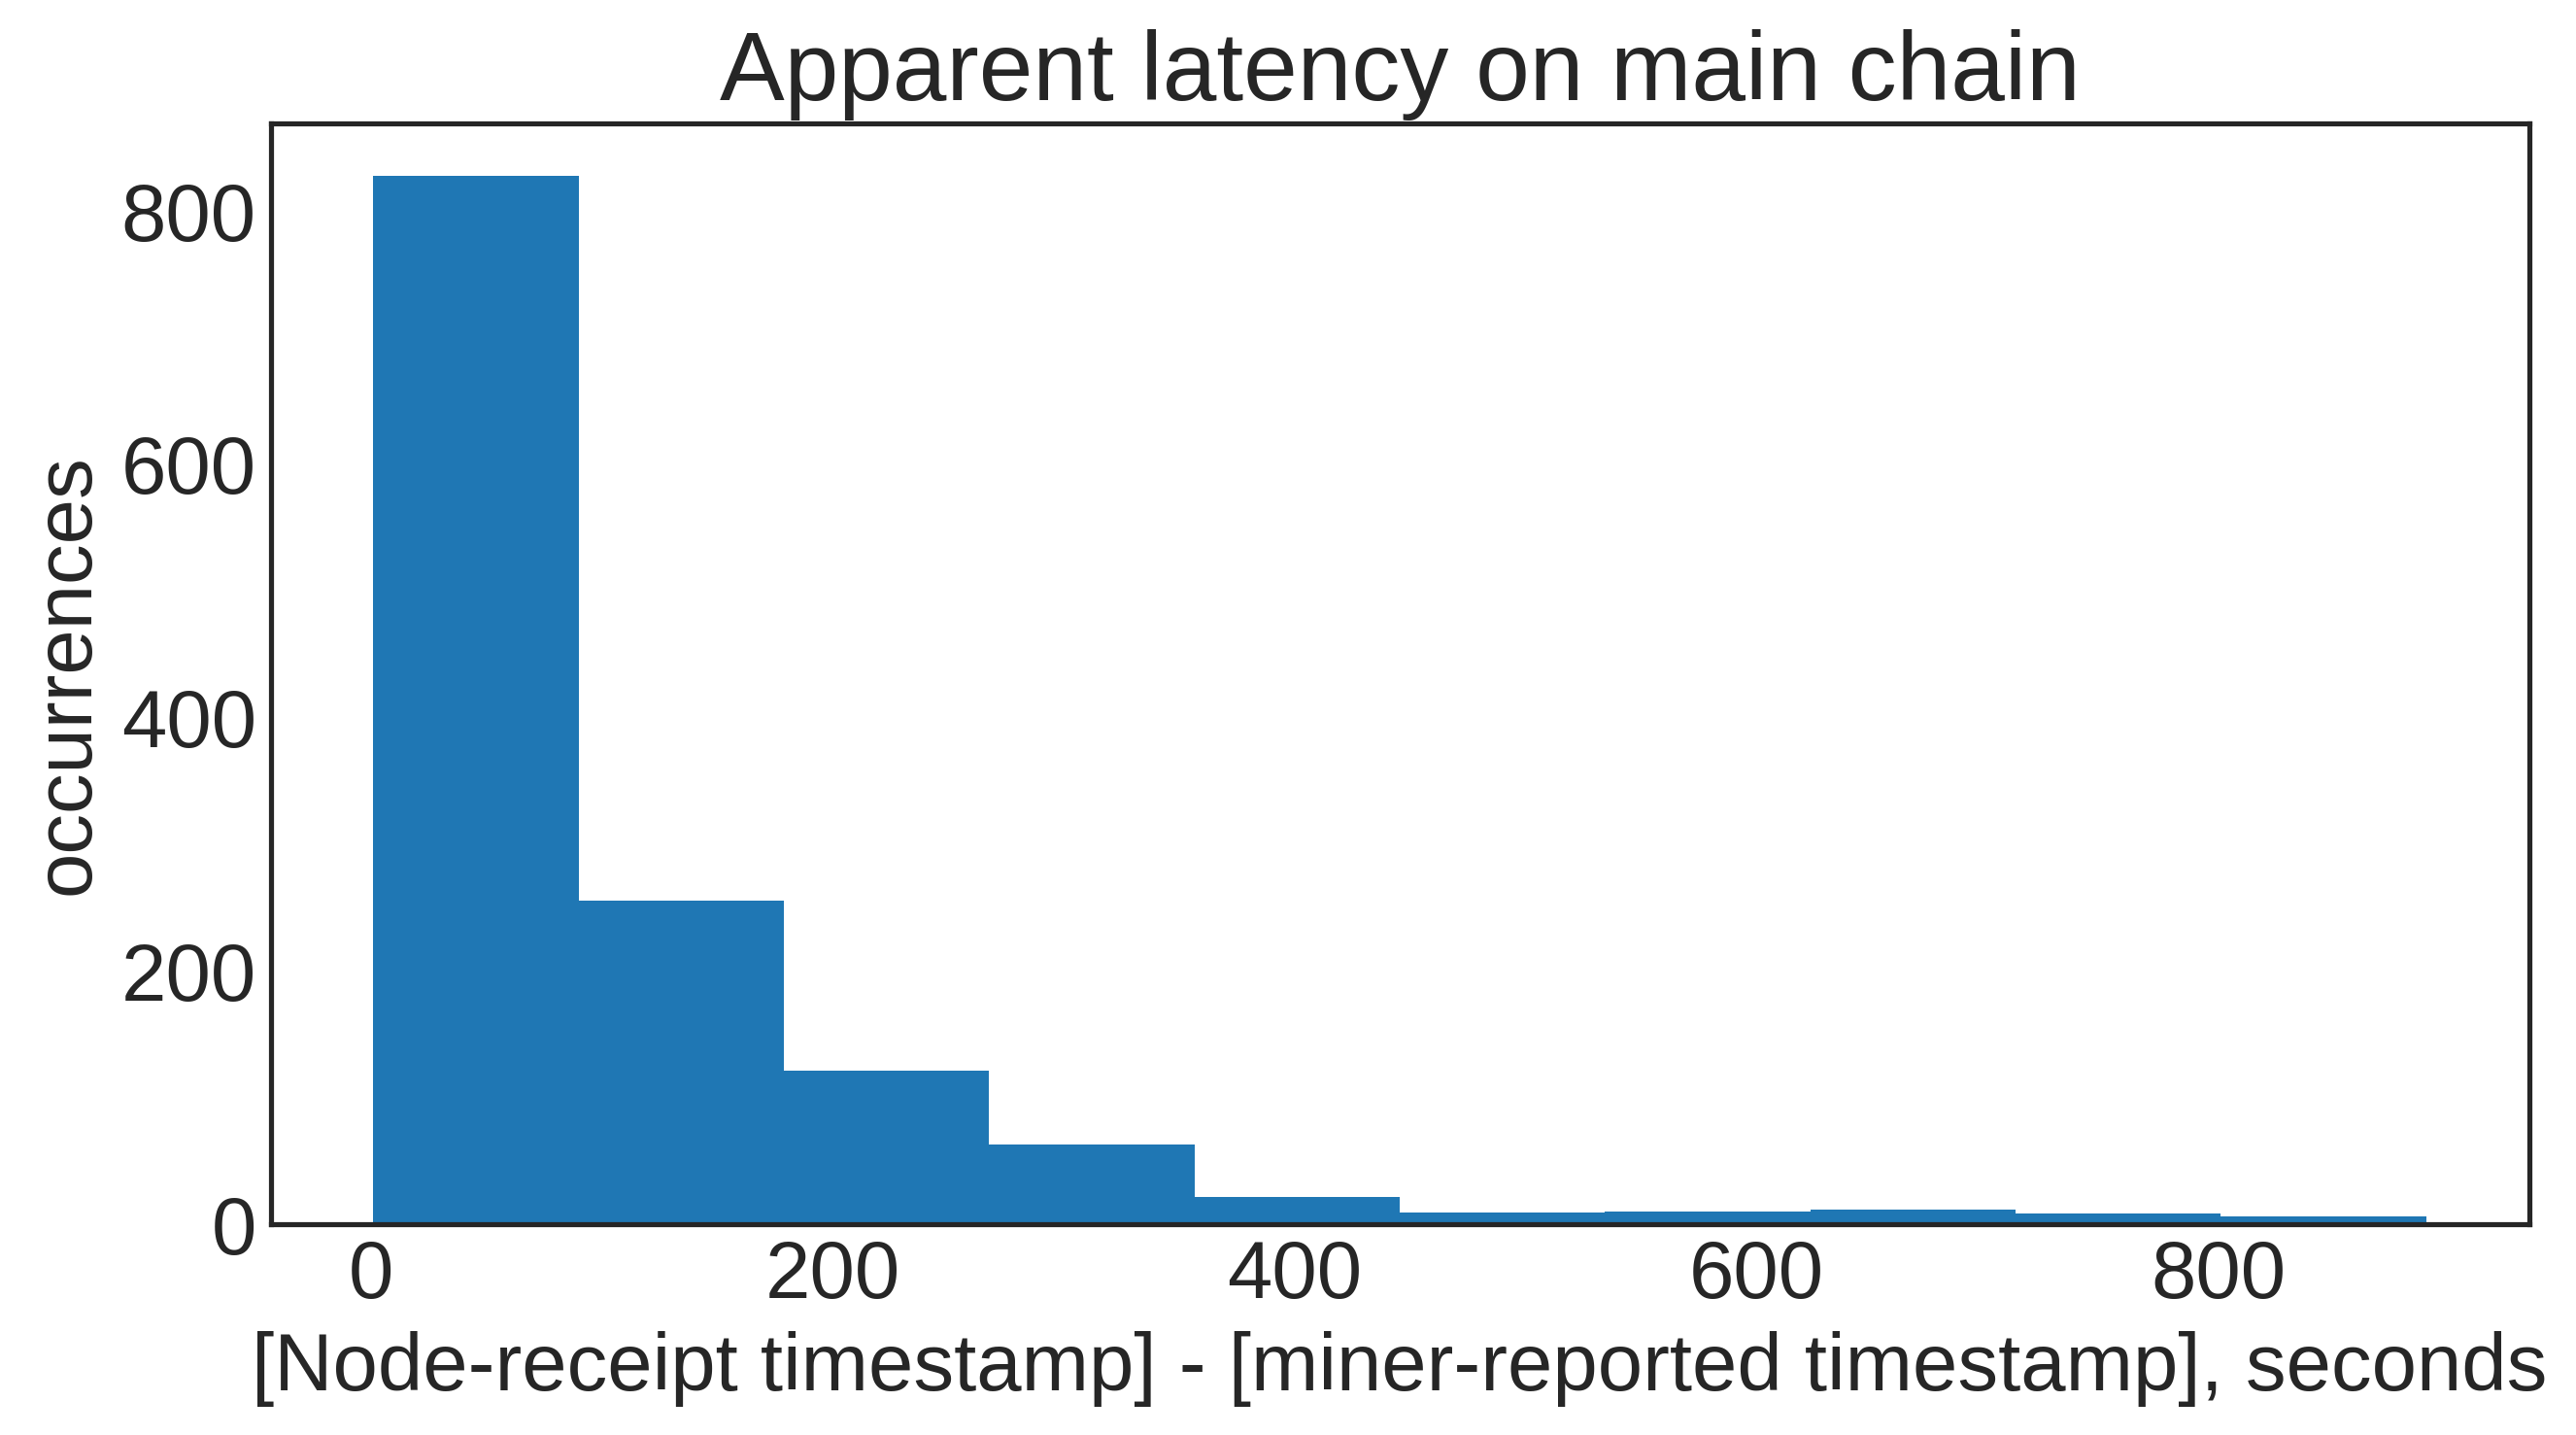

In [11]:
fig = plt.figure(figsize=(10,5),facecolor='white', dpi=300)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['font.size'] = 20

# Look only at blocks received at height, not during sync
df_at_height = df[df['height']>=blockchain_synced_at_height]

plt.hist(df_at_height.ostensible_detection_lag[df_at_height['main_chain']==1])

plt.xlabel('[Node-receipt timestamp] - [miner-reported timestamp], seconds')
plt.ylabel('occurrences')
plt.title('Apparent latency on main chain')
# plt.axvline(x=120, c='red', linestyle=':', linewidth=5)
pass

Are there any negative values? Meaning the the block was received before its miner reported timestamp? This should not happen (expect 0)

In [12]:
len(df[df['ostensible_detection_lag']<0])

0

Are there any Merlin blocks in this stretch of the main chain (meaning that the MRT is *earlier* than the MRT in the previous block)

In [13]:
len(df_main[df_main.merlin_block == 1])

0